In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
with open('spam.csv', 'r', encoding='ISO-8859-1') as file:
    # content = file.read()
    df = pd.read_csv(file)

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
txt = df['v2'][1000]
txt

'No..but heard abt tat..'

In [8]:
df.shape

(5572, 2)

In [9]:
import re
import spacy

nlp = spacy.load('en_core_web_sm')

def cleanTxt(txt):
  txt = txt.lower()
  txt = re.sub(r'[^a-zA-Z0-9]',' ',txt)
  txt = re.sub(r'\s+',' ',txt)

  doc = nlp(txt)
  clean_txt = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
  return ' '.join(clean_txt)

df['cleaned_txt'] = df['v2'].apply(cleanTxt)
df.head()

,v1,v2,cleaned_txt
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don t think go usf live


In [10]:
df.drop(['v2'],axis=1,inplace=True)
df.head()

,v1,cleaned_txt
0,ham,jurong point crazy available bugis n great wor...
1,ham,ok lar joke wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun early hor u c
4,ham,nah don t think go usf live


In [11]:
X = df['cleaned_txt']
y = df['v1']

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV

models = {
    'MultinomialNB':{
        'model':MultinomialNB(),
        'params':{
            'alpha':[1,2,3]
        }
    },
    'LogisticRegression':{
        'model':LogisticRegression(),
        'params':{
            'C':[1,2,3],
            'penalty':['l1','l2'],
            'solver':['liblinear','saga']
        }
    },
    'SVC':{
        'model':SVC(),
        'params':{
            'C':[1,2,3],
            'kernel':['linear','poly','rbf','sigmoid'],
        }
    }
}

best_estemator = {}
for model_name,calssifier in models.items():
  model = GridSearchCV(calssifier['model'],calssifier['params'],cv=5)
  model.fit(X_train_tf,y_train)
  y_pred = model.predict(X_test_tf)
  print(f'Model: {model_name}')
  print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
  best_estemator[model_name] = model.best_estimator_

Model: MultinomialNB
Accuracy: 0.9659192825112107
Model: LogisticRegression
Accuracy: 0.9695067264573991
Model: SVC
Accuracy: 0.9802690582959641


In [16]:
best_model = best_estemator['SVC']
best_model.fit(X_train_tf,y_train)
y_pred = best_model.predict(X_test_tf)
print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'Classification Report: \n{classification_report(y_test,y_pred)}')

Accuracy: 0.9802690582959641
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



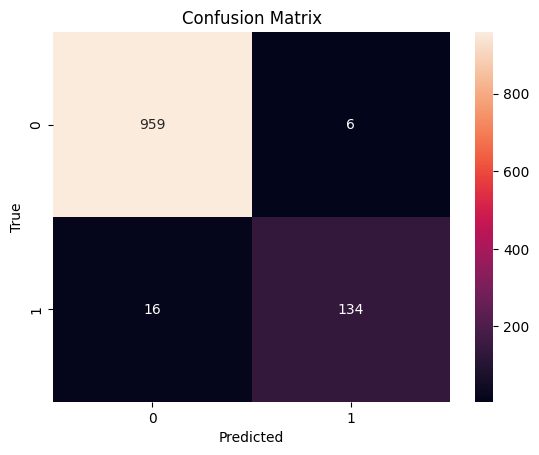

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()